In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, roc_auc_score, precision_score, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

pd.set_option('display.max_rows', 250)

In [2]:
df_ml_conso_validation = pd.read_csv('../../datasets/3_ml_patients_consolidation/df_ml_conso_validation.csv')
df_ml_conso_validation = df_ml_conso_validation.iloc[:,2:]
df_ml_conso_validation.head()

,qSQI_score,cSQI_score,sSQI_score,kSQI_score,pSQI_score,basSQI_score,classification
0,0.67,0.54,5.15,35.58,0.48,0.93,1
1,0.92,0.62,3.01,15.50,0.53,0.85,1
2,0.91,0.66,3.89,22.35,0.57,0.87,1
3,0.55,0.57,0.09,3.30,0.47,0.91,0
4,0.76,0.59,0.54,-0.44,0.51,0.72,0


In [3]:
df_ml_conso_balanced = pd.read_csv('../../datasets/3_ml_patients_consolidation/df_ml_conso_balanced.csv')
df_ml_conso_balanced = df_ml_conso_balanced.iloc[:,2:]
df_ml_conso_balanced.head()

,qSQI_score,cSQI_score,sSQI_score,kSQI_score,pSQI_score,basSQI_score,classification
0,0.64,0.57,2.71,9.90,0.52,0.95,0
1,0.72,0.62,3.55,15.64,0.51,0.96,0
2,0.95,0.57,2.59,11.31,0.51,0.88,0
3,0.85,0.59,2.97,10.79,0.51,0.94,0
4,0.92,0.64,3.93,17.05,0.53,0.92,0


In [4]:
def make_performance_report(model, X_train, X_test, y_train, y_test):

    print('\nPerformance report :\n')
    # Feedback of the best model
    print('Best parameters:',model.best_params_)
    print('Score of best estimator on train:',model.best_estimator_.score(X_train, y_train))
    print('Score of best estimator on test:',model.best_estimator_.score(X_test, y_test))

    # Creation of the predictions of y_train & y_test

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)


    # Output the accuracy and f1 score for the model
    print()
    print("Accuracy on train set :", accuracy_score(y_train, y_train_pred))
    print("Accuracy on test set :", accuracy_score(y_test, y_test_pred))
    print()

    print()
    print("f1-score on traina set :", f1_score(y_train, y_train_pred))
    print("f1-score on test set :", f1_score(y_test, y_test_pred))
    print()

    print()
    print("Recall on train set :", recall_score(y_train, y_train_pred))
    print("Recall on test set :", recall_score(y_test, y_test_pred))
    print()

    print()
    print("Precision on train set :", precision_score(y_train, y_train_pred))
    print("Precision on test set :", precision_score(y_test, y_test_pred))
    print()

    print()
    print("ROC_AUC_score on train set :", roc_auc_score(y_train, y_train_pred))
    print("ROC_AUC_score on test set :", roc_auc_score(y_test, y_test_pred))
    print()

    # Plot non-normalized confusion matrix
    titles_options = [("Confusion matrix, without normalization", None),
                    ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(model, X_test, y_test,
                                    display_labels=[0,1],
                                    cmap=plt.cm.Blues,
                                    normalize=normalize)
        disp.ax_.set_title(title)

    plt.show()

# I - Preprocessing

In [5]:
df = df_ml_conso_balanced

# Declaration of target and features_list

target_variable = 'classification'
features_list = df.columns.drop(target_variable)

X = df.loc[:, features_list]
y = df.loc[:, target_variable]

# Distinction of categorical features
# (string values, columns index for numpy use)

categorical_features_str = (X.select_dtypes(include=['object']).columns)
categorical_features = [X.columns.get_loc(i) for i in categorical_features_str]

print('categorical columns:',categorical_features)

# Distinction of numeric features 

numeric_features_str = X.columns.drop(categorical_features_str)
numeric_features = [X.columns.get_loc(i) for i in numeric_features_str]

print('numeric columns:',numeric_features)

# Division of dataset Train set & Test set 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convertion of pandas DataFrames to numpy arrays before using scikit-learn

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

print('Proportion of class 1 in y_train: ', np.mean(y_train))

print('Proportion of class 1 in y_test: ', np.mean(y_test))

# Declaration of the categorical and numeric transfomers

categorical_transformer = OneHotEncoder(drop='first')
numeric_transformer = StandardScaler()

# Declaration of the feature encoder

feature_encoder = ColumnTransformer(
transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
]
)

# Fit of the encoder on X_train and transform of X_train

# Fit on X

feature_encoder.fit(X_train)

print('Shape before feature encoder:', X_train.shape)
X_train = feature_encoder.transform(X_train)
print('Shape after feature encoder:', X_train.shape)

# Transformation of X_test
X_test = feature_encoder.transform(X_test)

categorical columns: []
numeric columns: [0, 1, 2, 3, 4, 5]
Proportion of class 1 in y_train:  0.500098833761613
Proportion of class 1 in y_test:  0.49960474308300395
Shape before feature encoder: (5059, 6)
Shape after feature encoder: (5059, 6)


In [6]:
# Preprocessing for validation dataset
df_val = df_ml_conso_validation

X_val = df_val.loc[:, features_list]
y_val = df_val.loc[:, target_variable]

X_val = feature_encoder.transform(X_val)

# II - Logistic Regression

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  40 | elapsed:    0.9s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  27 out of  40 | elapsed:    0.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  36 out of  40 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.0s finished
GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'class_weight': [True, False],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg']},
             scoring='recall', verbose=5)

Performance report :

Best parameters: {'class_weight': True, 'penalty': 'l2', 'solver': 'newton-cg'}
Score of best estimator on train: 0.8066811622850366
Score of best estimator on test: 0.8150197628458498

Accuracy on train set : 0.8066811622850366
Accuracy on te

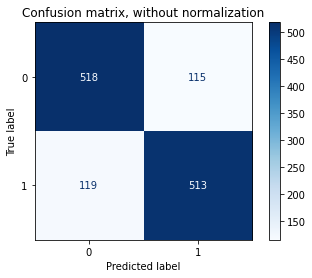

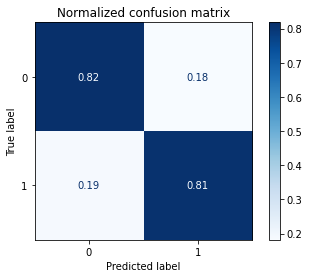

In [7]:
# Declaration of algorithm and parameters for gridsearch

algo = LogisticRegression()
params = {'class_weight' : [True, False],
          'solver' : ['newton-cg',],
          'penalty': ['l1', 'l2', 'elasticnet', 'none']
         }
grid_search_log = GridSearchCV(estimator=algo, param_grid= params, scoring='recall', cv = 5,verbose=5,n_jobs=-1)

# Fitting on train datas

grid_search_log.fit(X_train, y_train)
print(grid_search_log)
make_performance_report(grid_search_log , X_train, X_test, y_train, y_test)


Performance report :

Best parameters: {'class_weight': True, 'penalty': 'l2', 'solver': 'newton-cg'}
Score of best estimator on train: 0.8148846495119787
Score of best estimator on test: 0.8148846495119787

Accuracy on train set : 0.8148846495119787
Accuracy on test set : 0.8148846495119787


f1-score on traina set : 0.7587801705448765
f1-score on test set : 0.7587801705448765


Recall on train set : 0.8210822646230841
Recall on test set : 0.8210822646230841


Precision on train set : 0.7052659860290167
Precision on test set : 0.7052659860290167


ROC_AUC_score on train set : 0.8162809501496585
ROC_AUC_score on test set : 0.8162809501496585



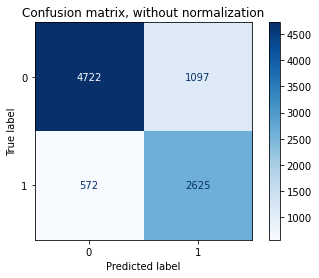

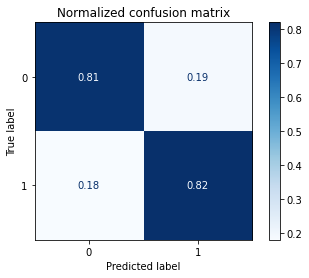

In [8]:
# Performance report on validation Dataset

make_performance_report(grid_search_log , X_val, X_val, y_val, y_val)

# III - ML - Random Forest Classifier

In [9]:
# Declaration of algorithm and parameters for gridsearch

algo = RandomForestClassifier()
params = {'class_weight' : [None, 'balanced'],
          'min_samples_leaf' : np.arange(6,12,1),
         'max_depth' :  np.arange(6,12,1),
         'max_features' : np.arange(6,12,1),
         'n_estimators' : np.arange(6,12,1),
         'criterion' : ['gini', 'entropy']
         }

RanClassRocAuc =  GridSearchCV(estimator=algo, param_grid= params, scoring='roc_auc', cv = 5,verbose=5,n_jobs=-1)

# grid_search_RFC_list = [RanClassRecall, RanClassAcc, RanClassPrecision, RanClassF1, RanClassRocAuc]

grid_search_RFC_list = [RanClassRocAuc]

# Fitting on train datas

for grid_search in grid_search_RFC_list:
    grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 5184 candidates, totalling 25920 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1408 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 4000 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 7168 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 10912 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 15232 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 20128 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 25525 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done 25920 out of 25920 | elapsed:   47.4s finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 6,  7,  8,  9, 10, 11]),
                         'max_features': array([ 6,  7,  8,  9, 10, 11]),
                         'min_samples_leaf': array([ 6,  7,  8,  9, 10, 11]),
                         'n_estimators': array([ 6,  7,  8,  9, 10, 11])},
             scoring='roc_auc', verbose=5)

Performance report :

Best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 11, 'max_features': 6, 'min_samples_leaf': 9, 'n_estimators': 11}
Score of best estimator on train: 0.9025499110496146
Score of best estimator on test: 0.8711462450592885

Accuracy on train set : 0.9025499110496146
Accuracy on test set : 0.8711462450592885


f1-score on traina set : 0.9046606072326436
f1-score on test set : 0.8723570869224745


Recall on train set 

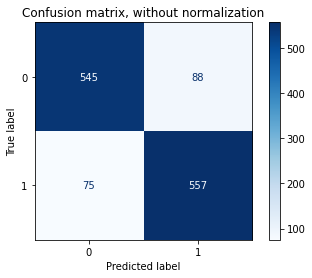

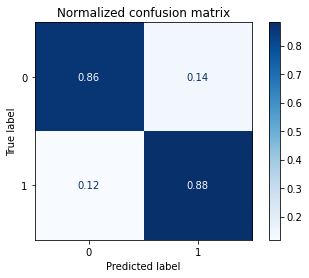

In [10]:
for grid_search in grid_search_RFC_list:
    print(grid_search)
    make_performance_report(grid_search , X_train, X_test, y_train, y_test)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 6,  7,  8,  9, 10, 11]),
                         'max_features': array([ 6,  7,  8,  9, 10, 11]),
                         'min_samples_leaf': array([ 6,  7,  8,  9, 10, 11]),
                         'n_estimators': array([ 6,  7,  8,  9, 10, 11])},
             scoring='roc_auc', verbose=5)

Performance report :

Best parameters: {'class_weight': True, 'penalty': 'l2', 'solver': 'newton-cg'}
Score of best estimator on train: 0.8148846495119787
Score of best estimator on test: 0.8148846495119787

Accuracy on train set : 0.8148846495119787
Accuracy on test set : 0.8148846495119787


f1-score on traina set : 0.7587801705448765
f1-score on test set : 0.7587801705448765


Recall on train set : 0.8210822646230841
Recall on test set : 0.8210822646230841


Precis

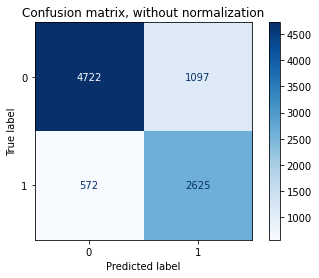

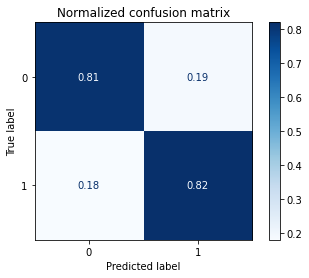

In [11]:
# Performance report on validation Dataset
for grid_search in grid_search_RFC_list:
    print(grid_search)
    make_performance_report(grid_search_log , X_val, X_val, y_val, y_val)


# IV - ML - XGBoost

In [12]:
# Declaration of algorithm and parameters for gridsearch

algo = XGBClassifier()
params = {'min_samples_leaf' : np.arange(6,12,1),
         'max_depth' :  np.arange(6,12,1),
         'max_features' : np.arange(6,12,1),
         'n_estimators' : np.arange(6,12,1),
         'criterion' : ['gini', 'entropy']
         }

params = {'class_weight': [None], 'criterion': ['entropy'], 'max_depth': [11], 'max_features': [6], 'min_samples_leaf': [8], 'n_estimators': [11],
'learning_rate': [0.20, 0.25, 0.30, 0.35, 0.40 ], 'gamma':[ 0.0, 0.1, 0.2]}

XGBClassRocAuc =  GridSearchCV(estimator=algo, param_grid= params, scoring='roc_auc', cv = 5,verbose=5,n_jobs=-1)

# grid_search_list = [RanClassRecall, RanClassAcc, RanClassPrecision, RanClassF1, RanClassRocAuc]

grid_search_XGB_list = [XGBClassRocAuc]

# Fitting on train datas

for grid_search in grid_search_XGB_list:
    grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:  1.0min remaining:   15.3s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  1.2min finished
[19:47:22] WARNING: ../src/learner.cc:541: 
Parameters: { criterion, max_features, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:47:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
  

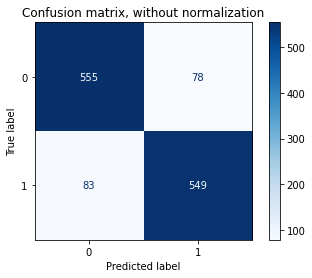

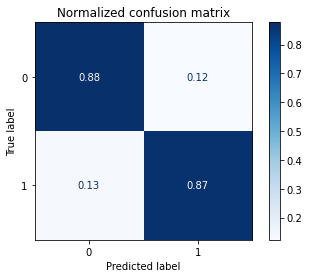

In [13]:
for grid_search in grid_search_XGB_list:
    print(grid_search)
    make_performance_report(grid_search , X_train, X_test, y_train, y_test)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
  

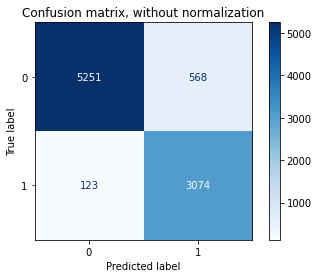

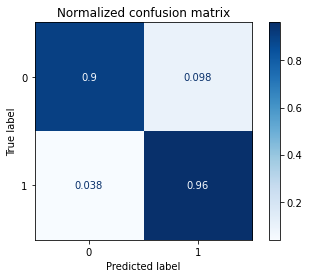

In [14]:
for grid_search in grid_search_XGB_list:
    print(grid_search)
    make_performance_report(grid_search , X_val, X_val, y_val, y_val)

# V - Export of models

In [15]:
# dump feature encoder
dump(feature_encoder, '../../ecg_qc/ml/data_encoder/data_encoder.joblib')

# dump RandomForestClassifier model
dump(grid_search_RFC_list[0].best_estimator_, '../../ecg_qc/ml/models/rfc.joblib')

# dump XGBoostClassifier model
dump(grid_search_XGB_list[0].best_estimator_, '../../ecg_qc/ml/models/xgb.joblib')

['../../ecg_qc/ml/models/xgb.joblib']